In [1]:
#from gcca import GCCA
import logging
# set log level
logging.root.setLevel(level=logging.INFO)
import numpy as np
from scipy import linalg,stats
from scipy.sparse.linalg import svds
# from sklearn.decomposition import TruncatedSVD
import glob
from tqdm import tqdm
from sklearn.preprocessing import normalize

from pathlib import Path
import re
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## See https://github.com/rupy/GCCA

## Load Data

In [2]:
basedir = Path('..')
datadir = basedir / 'data' / 'raw'
correlation_dir = basedir / 'data' / 'interim' / 'latents'

In [3]:
## Grab filenames
def get_files(level='(e|n)',
              subject='([0-9]{3})',
              task='(.+?)'):
    files = []
    query = f'^{level}_sub-'
    query += f'{subject}_ses-1_'
    query += f'task-{task}\.csv'
    for f in os.listdir(datadir):
        match = re.search(query, f)
        if match:
            files.append((f, match.groups()))
    
    return(files)

In [179]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

#for task,level in np.array(np.meshgrid(tasks,levels)).T.reshape(-1,2):
#    paths = get_files(level=level, task=task)

paths = get_files(level=levels[0], task=tasks[2])[:2]

In [181]:
data = []
subjs = []
for path,subj in paths:
    data.append(pd.read_csv(datadir / path, header = None).to_numpy())
    subjs.append(subj)

## GCCA

In [183]:
def _preprocess(x, var=False):
    x2 = stats.zscore(x,axis=1)
    x2 -= np.mean(x2,axis=0)
    return x2

def gcca(data, rank_tolerance=None, n_components=None):
    n = data[0].shape[0]

    data = [_preprocess(x) for x in data]
    
    Uall = []
    Sall = []
    Vall = []
    ranks = []
    
    for x in tqdm(data):
        # Preprocess
        x[np.isnan(x)] = 0

        # compute the SVD of the data
        v,s,ut = linalg.svd(x.T, full_matrices=False)

        Sall.append(s)
        Vall.append(v.T)
        # Dimensions to reduce to
        if rank_tolerance:
            rank = sum(s > rank_tolerance)
        else:
            rank = n_components
        ranks.append(rank)
        ut = ut.T[:,:rank]
        Uall.append(ut)

    d = min(ranks)

    # Create a concatenated view of Us
    Uall_c = np.concatenate(Uall,axis=1)

    _,_,VV=svds(Uall_c,d)
    VV = VV.T
    VV = VV[:,:min([d,VV.shape[1]])]

    # SVDS the concatenated Us
    idx_end = 0
    projX = []
    for i in range(len(data)):
        idx_start = idx_end
        idx_end = idx_start + ranks[i]
        VVi = normalize(VV[idx_start:idx_end,:],'l2',axis=0)
        # Compute the canonical projections
        A = np.sqrt(n-1) * Vall[i][:,:ranks[i]]
        A = A @ (linalg.solve(np.diag(Sall[i][:ranks[i]]), VVi))
        projX.append(data[i] @ A)
        
    return(projX)

In [ ]:
_preprocess(data[0])

In [158]:
normalize(np.array([[1,2,3],[4,5,6]]),'l2',axis=0)

array([[0.24253563, 0.37139068, 0.4472136 ],
       [0.9701425 , 0.92847669, 0.89442719]])

In [160]:
num_views = 2 # Number of subjects (views) to consider
rank_tolerance = 300

In [187]:
projs = gcca(data, n_components=4)#rank_tolerance=300)

mean: [ 0.07736506 -0.45932136 -0.54637519  0.24716229  0.34641152 -0.32244049
 -0.10411971  0.47131719 -0.07793666 -0.18052536 -0.20962831 -0.49246724
  0.00549495  0.17903927 -0.09618744  0.17210437  0.4851083   0.49502892
  0.00692034 -0.44654651  0.00378963 -0.00580319 -0.10381286 -0.21480373
 -0.25960714 -0.31255805  0.56947604  0.24942731 -0.51054655 -0.56215951
 -0.42607986  0.35738929  0.18393718 -0.26534387 -0.1004228   0.41635576
 -0.18237208 -0.27552275 -0.41465698  0.09762074  0.3388311   0.17112348
 -0.30581949 -0.23450316 -0.36611338 -0.01730493  0.18024671  0.32589782
  0.0612461  -0.02606633  0.36068132  0.10610061  0.18597747 -0.30980384
 -0.0218798   0.37328289 -0.29748786 -0.56740866  0.05673162  0.21860403
  0.01059093 -0.08257938 -0.49299316  0.03069005  0.08462869  0.06658781
 -0.03464364 -0.1649478   0.06866107  0.56515595 -0.08825859 -0.18611804
  0.17904814 -0.07628873  0.05613087 -0.10954415 -0.00215701  0.2266504
  0.16799441 -0.03222575  0.21958445  0.277318

  0%|          | 0/2 [00:00<?, ?it/s]

mean: [ 0.28370612 -0.20760158 -0.29822028  0.0954144   0.57022811  0.23880127
  0.2349236   0.03301714  0.39371414  0.03276676  0.55149429  0.29750735
  0.21809456 -0.07573668 -0.05023935  0.02356737  0.66048952  0.32510482
 -0.33872622  0.1088757  -0.43876324  0.00659002  0.18496635 -0.42604077
  0.49220177 -0.18491347 -0.11899373 -0.20427003 -0.15296495  0.59924052
  1.33773779  0.62541461 -0.55741202 -0.5638704  -0.51524602 -0.80915002
 -1.77531924 -1.26270741 -1.20175739 -1.09677957 -1.22512623 -1.05369833
 -0.54201645 -0.37900115 -0.7992552  -0.87516097 -0.20879491 -0.40316157
 -0.64658077 -0.71916774 -0.19904911 -0.00432305 -0.25017377 -0.69494097
 -0.50039597 -0.22557348 -0.09400625 -0.31536101 -0.79771949 -0.49477366
 -0.07130943  0.41441833  0.52677766 -0.46774877 -0.58651137  0.03141335
  0.39450029 -0.04216657 -0.42057394 -0.64547432  0.30410916  0.29989714
 -0.22548197 -0.54578067 -0.51745605 -1.16232324 -0.91184869 -0.17844881
  0.69633738  0.59152223  0.23925808  0.18460

100%|██████████| 2/2 [00:05<00:00,  2.67s/it]

[[-0.24446481  0.09743932 -0.10916648 -0.64716707]
 [ 0.43392512 -0.48018721 -0.20040064 -0.20240755]
 [ 0.14648734 -0.0700304   0.66479071 -0.17801829]
 [-0.48009104 -0.5049966   0.07730182  0.09227922]]
[[-0.34572544  0.13780001 -0.15438472 -0.91523245]
 [ 0.61366279 -0.67908726 -0.28340931 -0.28624751]
 [ 0.20716438 -0.09903794  0.94015604 -0.25175588]
 [-0.67895126 -0.71417304  0.10932128  0.13050252]]
[[-0.10217067  0.23010335  0.05980238 -0.65805568]
 [-0.37517542  0.08674008 -0.5920389   0.03477786]
 [-0.42060123  0.39302999  0.337831    0.23343576]
 [-0.41460724 -0.53390639  0.1782802  -0.10611772]]
[[-0.14449114  0.32541528  0.08457334 -0.93063127]
 [-0.53057817  0.122669   -0.83726945  0.04918332]
 [-0.59481996  0.55582834  0.47776518  0.33012801]
 [-0.58634319 -0.75505766  0.25212628 -0.15007312]]


## GCCA Rupy Implementation

In [12]:
import numpy as np
from scipy.linalg import eig
import logging
import os
import matplotlib.pyplot as plt
import math
from matplotlib import colors
import h5py

class GCCA:

    def __init__(self, n_components=2, reg_param=0.1):

        # log setting
        program = os.path.basename(__name__)
        self.logger = logging.getLogger(program)
        logging.basicConfig(format='%(asctime)s : %(name)s : %(levelname)s : %(message)s')

        # GCCA params
        self.n_components = n_components
        self.reg_param = reg_param

        # result of fitting
        self.data_num = 0
        self.cov_mat = [[]]
        self.h_list = []
        self.eigvals = np.array([])

        # result of transformation
        self.z_list = []

    def eigvec_normalization(self, eig_vecs, x_var):
        self.logger.info("normalization")
        z_var = np.dot(eig_vecs.T, np.dot(x_var, eig_vecs))
        invvar = np.diag(np.reciprocal(np.sqrt(np.diag(z_var))))
        eig_vecs = np.dot(eig_vecs, invvar)
        # print np.dot(eig_vecs.T, np.dot(x_var, eig_vecs)).round().astype(int)
        return eig_vecs


    def solve_eigprob(self, left, right):

        self.logger.info("calculating eigen dimension")
        eig_dim = min([np.linalg.matrix_rank(left), np.linalg.matrix_rank(right)])

        self.logger.info("calculating eigenvalues & eigenvector")
        eig_vals, eig_vecs = eig(left, right)

        self.logger.info("sorting eigenvalues & eigenvector")
        sort_indices = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[sort_indices][:eig_dim].real
        eig_vecs = eig_vecs[:,sort_indices][:,:eig_dim].real

        return eig_vals, eig_vecs

    def calc_cov_mat(self, x_list):

        data_num = len(x_list)

        self.logger.info("calc variance & covariance matrix")
        z = np.vstack([x.T for x in x_list])
        cov = np.cov(z)
        d_list = [0] + [sum([len(x.T) for x in x_list][:i + 1]) for i in range(data_num)]
        cov_mat = [[np.array([]) for col in range(data_num)] for row in range(data_num)]
        for i in range(data_num):
            for j in range(data_num):
                i_start, i_end = d_list[i], d_list[i + 1]
                j_start, j_end = d_list[j], d_list[j + 1]
                cov_mat[i][j] = cov[i_start:i_end, j_start:j_end]

        return cov_mat

    def add_regularization_term(self, cov_mat):

        data_num = len(cov_mat)

        # regularization
        self.logger.info("adding regularization term")
        for i in range(data_num):
            cov_mat[i][i] += self.reg_param * np.average(np.diag(cov_mat[i][i])) * np.eye(cov_mat[i][i].shape[0])

        return cov_mat

    def fit(self, *x_list):

        # data size check
        data_num = len(x_list)
        self.logger.info("data num is %d", data_num)
        for i, x in enumerate(x_list):
            self.logger.info("data shape x_%d: %s", i, x.shape)

        self.logger.info("normalizing")
        x_norm_list = [ self.normalize(x) for x in x_list]

        d_list = [0] + [sum([len(x.T) for x in x_list][:i + 1]) for i in range(data_num)]
        cov_mat = self.calc_cov_mat(x_norm_list)
        cov_mat = self.add_regularization_term(cov_mat)

        self.logger.info("calculating generalized eigenvalue problem ( A*u = (lambda)*B*u )")
        # left = A, right = B
        left = 0.5 * np.vstack(
            [
                np.hstack([np.zeros_like(cov_mat[i][j]) if i == j else cov_mat[i][j] for j in range(data_num)])
                for i in range(data_num)
            ]
        )
        right = np.vstack(
            [
                np.hstack([np.zeros_like(cov_mat[i][j]) if i != j else cov_mat[i][j] for j in range(data_num)])
                for i in range(data_num)
            ]
        )

        # calc GEV
        self.logger.info("solving")
        eigvals, eigvecs = self.solve_eigprob(left, right)

        h_list = [eigvecs[start:end] for start, end in zip(d_list[0:-1], d_list[1:])]
        h_list_norm = [self.eigvec_normalization(h, cov_mat[i][i]) for i, h in enumerate(h_list)]

        # substitute local variables for member variables
        self.data_num = data_num
        self.cov_mat = cov_mat
        self.h_list = h_list_norm
        self.eigvals = eigvals

    def transform(self, *x_list):

        # data size check
        data_num = len(x_list)
        self.logger.info("data num is %d", data_num)
        for i, x in enumerate(x_list):
            self.logger.info("data shape x_%d: %s", i, x.shape)

        if self.data_num != data_num:
            raise Exception('data num when fitting is different from data num to be transformed')

        self.logger.info("normalizing")
        x_norm_list = [ self.normalize(x) for x in x_list]

        self.logger.info("transform matrices by GCCA")
        z_list = [np.dot(x, h_vec) for x, h_vec in zip(x_norm_list, self.h_list)]

        self.z_list = z_list

        return z_list

    def fit_transform(self, *x_list):
        self.fit(x_list)
        self.transform(x_list)

    @staticmethod
    def normalize(mat):
        m = np.mean(mat, axis=0)
        mat = mat - m
        return mat

    def save_params(self, filepath):

        self.logger.info("saving to %s", filepath)
        with h5py.File(filepath, 'w') as f:
            f.create_dataset("n_components", data=self.n_components)
            f.create_dataset("reg_param", data=self.reg_param)
            f.create_dataset("data_num", data=self.data_num)

            cov_grp = f.create_group("cov_mat")
            for i, row in enumerate(self.cov_mat):
                for j, cov in enumerate(row):
                    cov_grp.create_dataset(str(i) + "_" + str(j), data=cov)

            h_grp = f.create_group("h_list")
            for i, h in enumerate(self.h_list):
                h_grp.create_dataset(str(i), data=h)

            f.create_dataset("eig_vals", data=self.eigvals)

            if len(self.z_list) != 0:
                z_grp = f.create_group("z_list")
                for i, z in enumerate(self.z_list):
                    z_grp.create_dataset(str(i), data=z)
            f.flush()

    def load_params(self, filepath):
        self.logger.info("loading from %s", filepath)
        with h5py.File(filepath, "r") as f:
            self.n_components = f["n_components"].value
            self.reg_param = f["reg_param"].value
            self.data_num = f["data_num"].value

            self.cov_mat = [[np.array([]) for col in range(self.data_num)] for row in range(self.data_num)]
            for i in range(self.data_num):
                for j in range(self.data_num):
                    self.cov_mat[i][j] = f["cov_mat/" + str(i) + "_" + str(j)]
            self.h_list = [None] * self.data_num
            for i in range(self.data_num):
                self.h_list[i] = f["h_list/" + str(i)].value
            self.eig_vals = f["eig_vals"].value

            if "z_list" in f:
                self.z_list = [None] * self.data_num
                for i in range(self.data_num):
                    self.z_list[i] = f["z_list/" + str(i)].value
            f.flush()

    def plot_result(self):

        self.logger.info("plotting result")
        col_num = int(math.ceil(math.sqrt(self.data_num + 1)))
        row_num = int((self.data_num + 1) / float(col_num))
        if row_num != (self.data_num + 1) / float(col_num):
            row_num += 1

        # begin plot
        plt.figure()

        color_list = colors.cnames.keys()
        for i in range(self.data_num):

            plt.subplot(row_num, col_num, i + 1)
            plt.plot(self.z_list[i][:, 0], self.z_list[i][:, 1], c=color_list[i], marker='.', ls=' ')
            plt.title("Z_%d(GCCA)" % (i + 1))

        plt.subplot(row_num, col_num, self.data_num + 1)
        for i in range(self.data_num):
            plt.plot(self.z_list[i][:, 0], self.z_list[i][:, 1], c=color_list[i], marker='.', ls=' ')
            plt.title("Z_ALL(GCCA)")

        plt.show()

    def calc_correlations(self):
        for i, z_i in enumerate(self.z_list):
            for j, z_j in enumerate(self.z_list):
                if i < j:
                   print("(%d, %d): %f" % (i, j, np.corrcoef(z_i[:,0], z_j[:,0])[0, 1]))

In [19]:
gcca = GCCA(n_components=4, reg_param=0)
gcca.fit(data[0], data[1])
projs2 = gcca.transform(data[0], data[1])

2019-07-25 06:06:51,188 : __main__ : INFO : data num is 2
2019-07-25 06:06:51,192 : __main__ : INFO : data shape x_0: (18715, 300)
2019-07-25 06:06:51,195 : __main__ : INFO : data shape x_1: (18715, 300)
2019-07-25 06:06:51,196 : __main__ : INFO : normalizing
2019-07-25 06:06:51,350 : __main__ : INFO : calc variance & covariance matrix
2019-07-25 06:06:51,801 : __main__ : INFO : adding regularization term
2019-07-25 06:06:51,803 : __main__ : INFO : calculating generalized eigenvalue problem ( A*u = (lambda)*B*u )
2019-07-25 06:06:51,822 : __main__ : INFO : solving
2019-07-25 06:06:51,823 : __main__ : INFO : calculating eigen dimension
2019-07-25 06:06:52,047 : __main__ : INFO : calculating eigenvalues & eigenvector
2019-07-25 06:06:54,691 : __main__ : INFO : sorting eigenvalues & eigenvector
2019-07-25 06:06:54,694 : __main__ : INFO : normalization
2019-07-25 06:06:54,722 : __main__ : INFO : normalization
2019-07-25 06:06:54,771 : __main__ : INFO : data num is 2
2019-07-25 06:06:54,772

## CCA

In [11]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=4)
cca.fit(data[0],data[1])


X_c, Y_c = cca.transform(data[0],data[1])

## Compare

In [25]:
import graspy
from graspy.plot import pairplot
%matplotlib inline

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


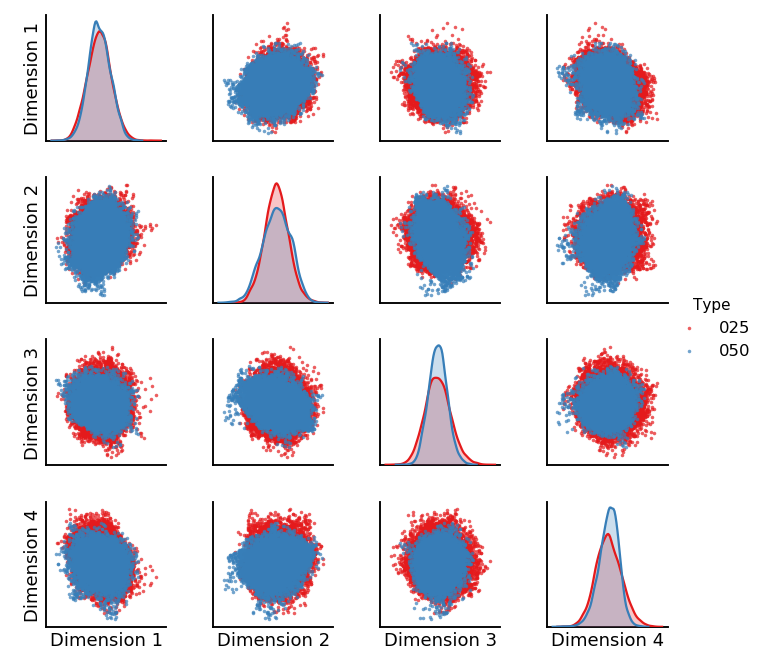

In [188]:
## My Python
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in subjs)))

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


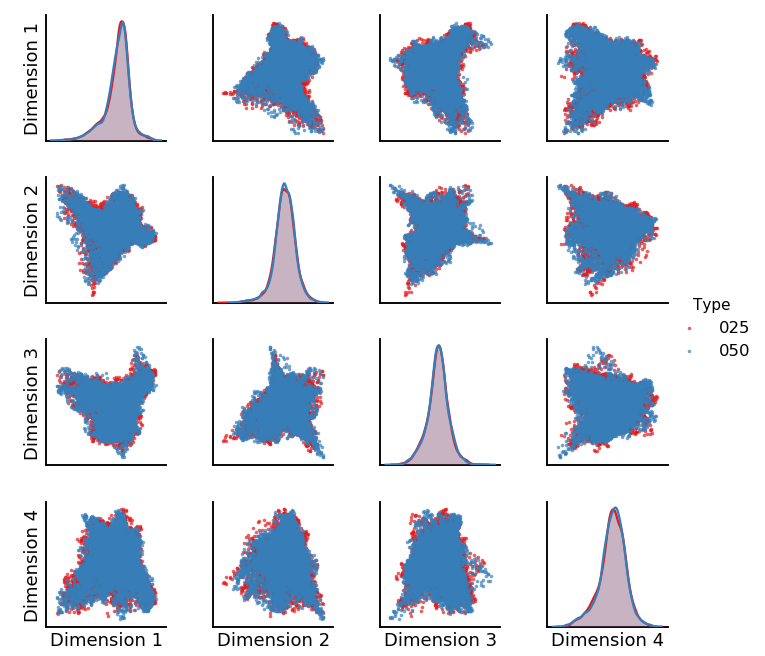

In [29]:
## Rupy Implementation
pairplot(np.vstack(projs2)[:,:4], labels=np.hstack((i*projs2[0].shape[0] for i in subjs)))

### Load MATLAB GCCA results

In [204]:
pathsM = []
subjsM = []
for f in os.listdir(basedir / 'data'):
    if f[-3:] == 'csv':
        pathsM.append(basedir / 'data' / f)
        subjsM.append('_'.join(f[:-4].split('_')[1:]))

In [210]:
projsM[0].shape

(18715, 4)

In [206]:
projsM = []
for f in pathsM:
    projsM.append(pd.read_csv(f, header=None).to_numpy()[:,:4])

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


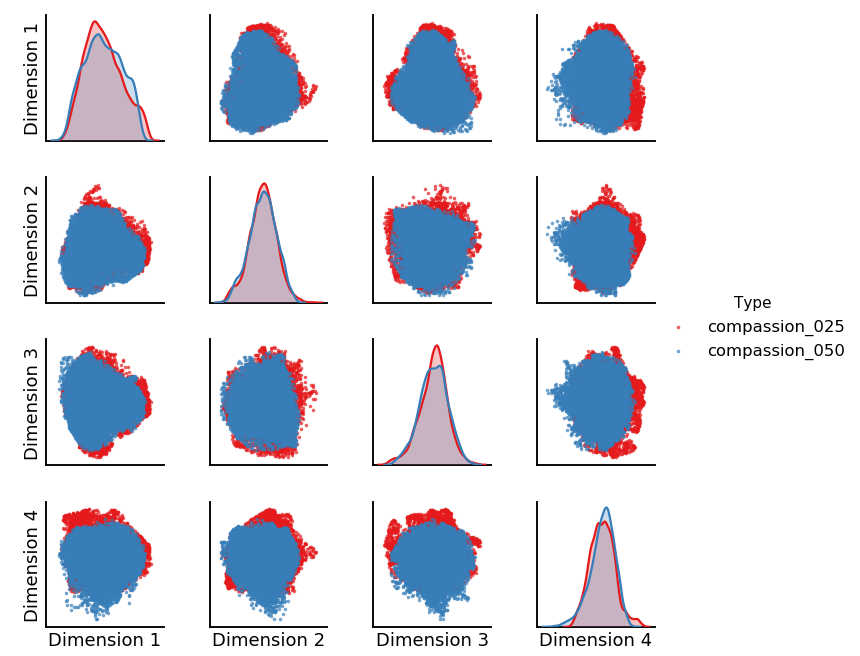

In [207]:
pairplot(np.vstack(projsM[:2]), labels=np.hstack(([i]*projsM[0].shape[0] for i in subjsM[:2])))